In [315]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [316]:
now = datetime.now()

Пути к директориям

In [317]:
TRAIN_DATASET_PATH = 'Desktop/NUMPY, Pandas/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'Desktop/NUMPY, Pandas/real-estate-price-prediction-moscow/test.csv'

Функция для подсчета метрик

In [318]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загрузка данных

In [319]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.shape

(10000, 20)

In [320]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [321]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [322]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [323]:
test_df.shape

(5000, 19)

In [324]:
test_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
5,868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
7,2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B
8,4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
9,8354,62,2.0,62.593787,59.786844,10.0,1,16.0,1981,0.002212,B,B,39,7614,3,NaN,1,5,A


In [325]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Целевая переменная

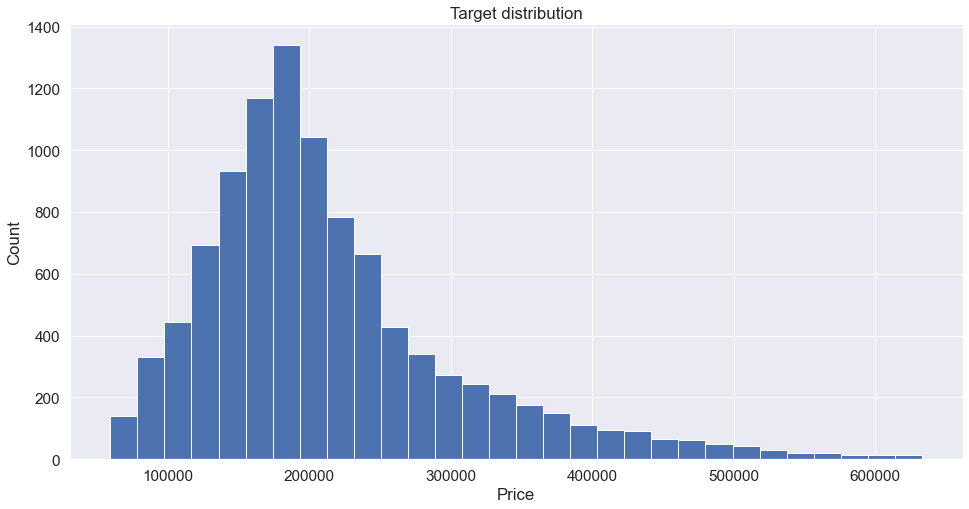

In [326]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Коррелляции

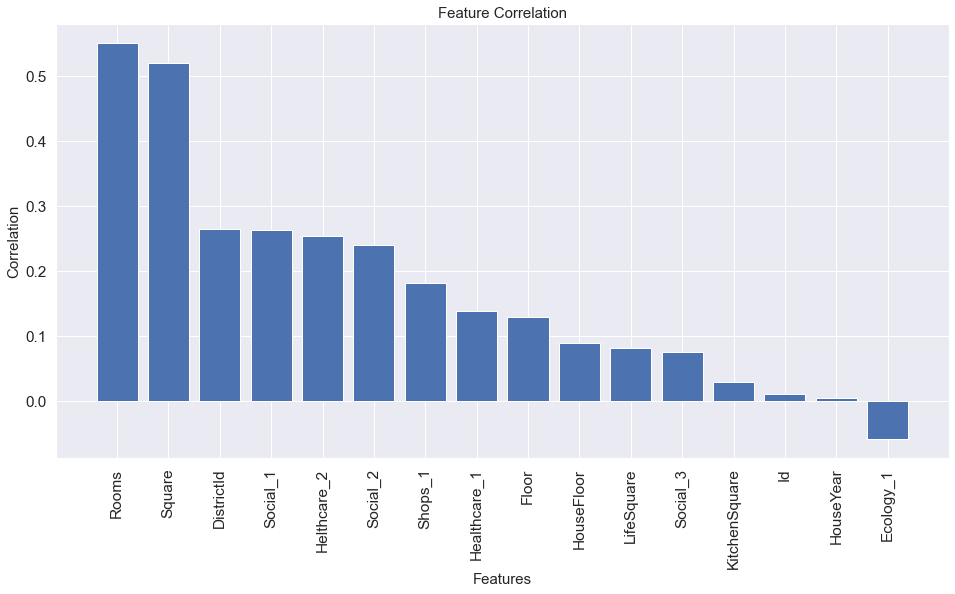

In [327]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)


plt.figure(figsize = (16,8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')

  
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature Correlation', fontsize=15)
plt.show()

In [328]:
train_df['Id'] = train_df['Id'].astype(str)
test_df['Id'] = test_df['Id'].astype(str)

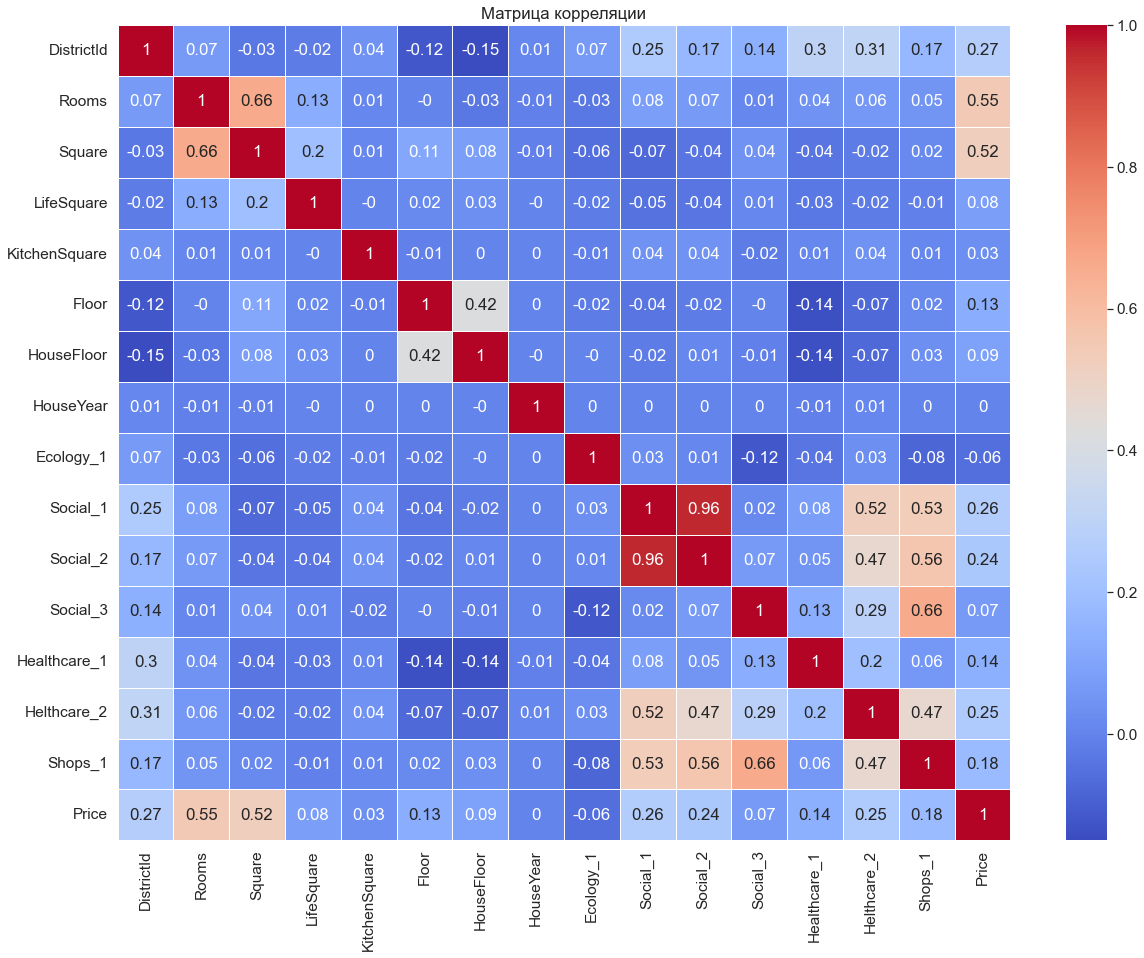

In [329]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

EDA 
1. Обработка выбросов

In [330]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Выбросы по 'HouseYear'

In [331]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

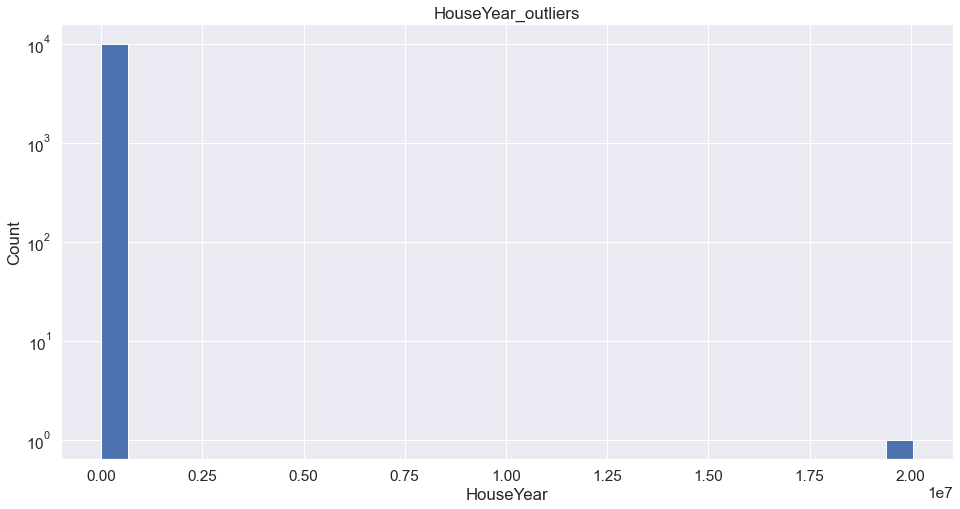

In [332]:
plt.figure(figsize = (16, 8))

train_df['HouseYear'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('HouseYear')
plt.yscale(value='log')
plt.title('HouseYear_outliers')
plt.show()

In [19]:
train_df['HouseYear_outlier'] = 0
train_df.loc[(train_df['HouseYear'] == 0) | (train_df['HouseYear'] > 2022) | (train_df['HouseYear'] < 1900), 'HouseYear_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [20]:
train_df['HouseYear_outlier'].value_counts()

0    9998
1       2
Name: HouseYear_outlier, dtype: int64

In [21]:
train_df['HouseYear'].value_counts().loc[lambda x : x == 1]

1947        1
1914        1
1928        1
1910        1
1916        1
4968        1
20052011    1
Name: HouseYear, dtype: int64

In [333]:
train_df.loc[(train_df['HouseYear'] == 4968), 'HouseYear'] = 1968

In [334]:
train_df.loc[(train_df['HouseYear'] == 20052011), 'HouseYear'] = 2005

In [335]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [336]:
train_df[train_df['Rooms'].isin([0, 6, 10, 19])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Выбросы по площади:

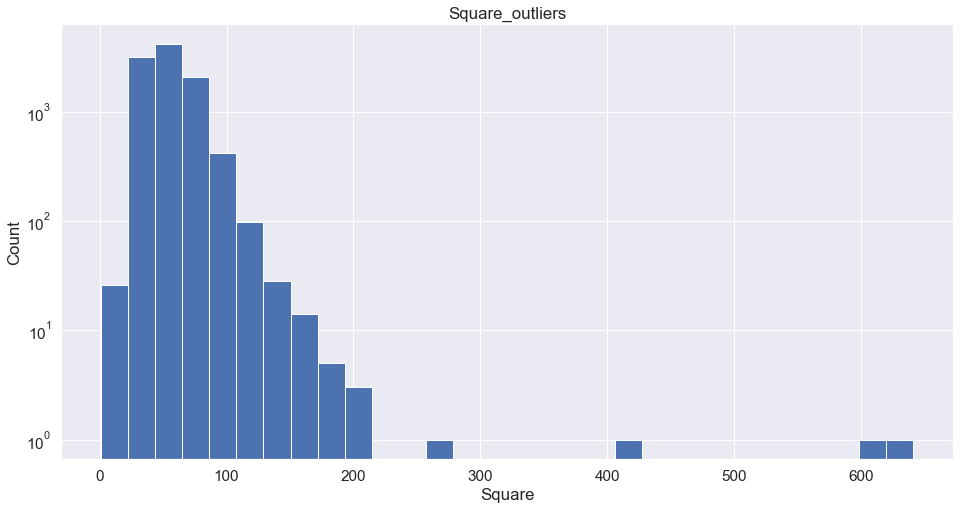

In [337]:
plt.figure(figsize = (16, 8))

train_df['Square'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Square')
plt.yscale(value='log')
plt.title('Square_outliers')
plt.show()

Выбросы по этажам:

In [338]:
train_df.loc[train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184


Выбросы по площадям:

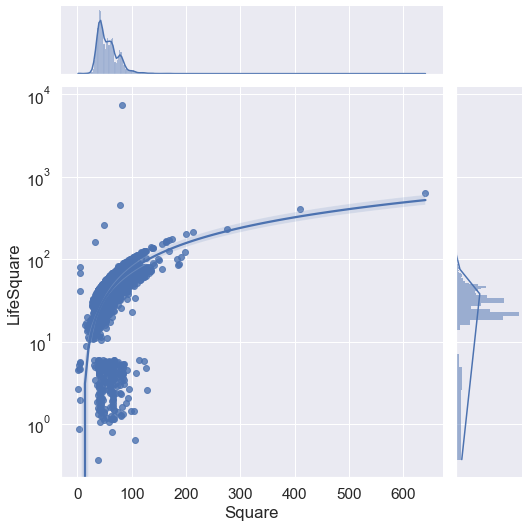

In [339]:
grid =sns.jointplot(train_df['Square'], train_df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.yscale(value='log')
plt.show()

Выбросы по KitchenSquare:

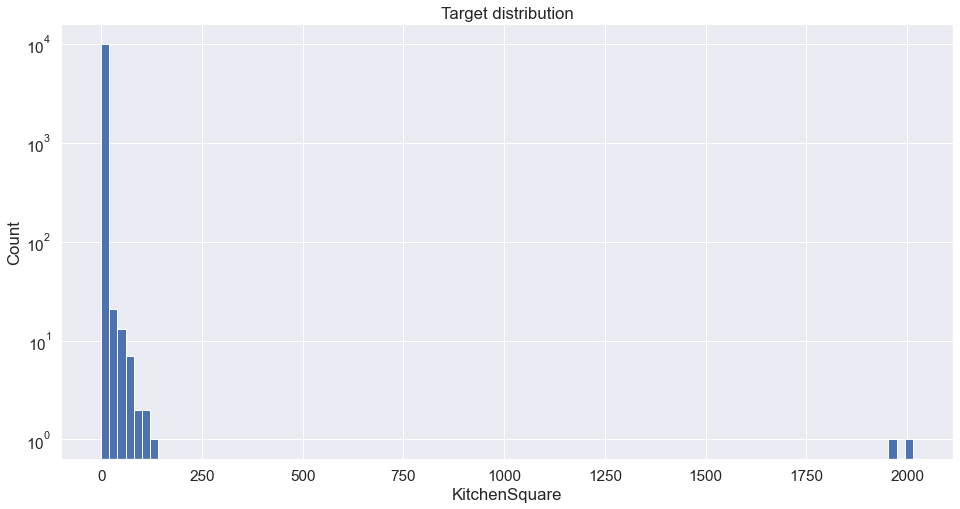

In [340]:
plt.figure(figsize = (16, 8))

train_df['KitchenSquare'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

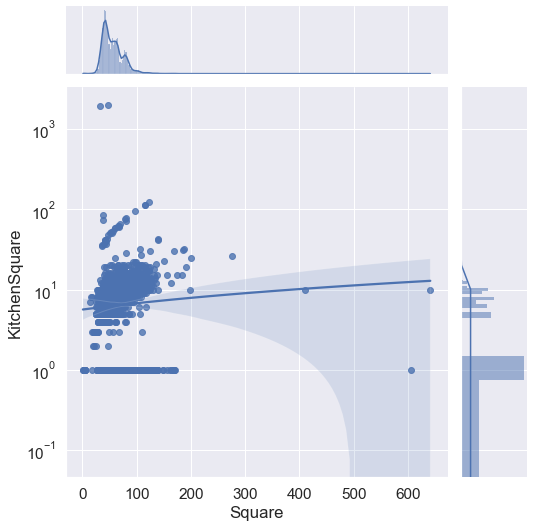

In [341]:
grid =sns.jointplot(train_df['Square'], train_df['KitchenSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.yscale(value='log')
plt.show()

In [342]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.max = None
        self.min = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.rooms_median = X['Rooms'].median()
        self.square_median = X['Square'].median()
        self.room_max = X['Rooms'].max()
        self.housefloor_mode = X['HouseFloor'].mode()[0]
        self.kitchensquare_median = X['KitchenSquare'].median()
        
        
    def transform(self, X):
        """Трансформация данных"""
        
        X.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # Square
        X.loc[X['Square']>=300, 'Square'] = self.square_median
        X.loc[X['Square']<15, 'Square'] = self.square_median
    
      
        
        
        # Rooms    
        
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.rooms_median
        X.loc[(X['Rooms'] == 0) & (X['Square'] > 100), 'Rooms'] = self.room_max
        X.loc[(X['Rooms'] == 0) & (X['Square'] < 100), 'Rooms'] = self.rooms_median
        
        # KitchenSquare
        X.loc[X['KitchenSquare']>20, 'KitchenSquare'] = self.kitchensquare_median
        X.loc[X['KitchenSquare']<3, 'KitchenSquare'] = self.kitchensquare_median
        # HouseFloor, Floor
        
        X.loc[X['HouseFloor']==0, 'HouseFloor'] = self.housefloor_mode
        X['Floor_outlier'] = 0
        X.loc[X.loc[X['Floor'] > X['HouseFloor']].index, 'Floor_outlier'] = 1
        floor_df = pd.DataFrame(X['Floor'])
        floor_df.loc[~((floor_df.index.isin(X.index))&(X['Floor_outlier'] == 0)),:]
        X['Floor'].where(~(X['Floor_outlier'] == 1), other=X['HouseFloor'], inplace=True)
        X['HouseFloor'].where(~(X['Floor_outlier'] == 1), other=floor_df['Floor'], inplace=True)
                
        
                    
        # LifeSquare
        X['LifeSquare'].where(~(X['LifeSquare'] > 300), other=X['LifeSquare']/10, inplace=True)
        X['LifeSquare'].where(~(X['LifeSquare'] > 700), other=X['LifeSquare']/100, inplace=True)
        X['LifeSquare_outlier'] = 0
        X.loc[X.loc[X['LifeSquare'] > X['Square']].index, 'LifeSquare_outlier'] = 1
        square_df = pd.DataFrame(X['Square'])
        square_df = square_df.loc[~((square_df.index.isin(X.index))&(X['LifeSquare_outlier'] == 0)),:]
        X['Square'].where(~(X['LifeSquare_outlier'] == 1), other=X['LifeSquare'], inplace=True)
        X['LifeSquare'].where(~(X['LifeSquare_outlier'] == 1), other=square_df['Square'], inplace=True)
        X['LifeSquare'].where(~(X['LifeSquare'] < 10), other=X['LifeSquare']+10, inplace=True)
        X['LifeSquare'].where(~(X['LifeSquare'] < 20), other=X['Square']*0.6, inplace=True)
        
        
        
        
        return X

In [343]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
preprocessor.fit(test_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

Обработаем выбросы по 'Rooms'. 
Заменим значения количества комнат больше 5 и равные 0(с площадью < 100), на median, 
значения, равные 0 с площадью больше 100 на max:

In [84]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Floor_outlier,LifeSquare_outlier,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,1,305018.871089,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,NaN,6.0,10,22.0,1977,0.007122,...,0,NaN,0,1,1,168106.007630,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,NaN,0,6,1,343995.102962,0,0,0,0


In [ ]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [ ]:
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] > 100), 'Rooms'] = train_df['Rooms'].max()

In [1230]:
train_df.loc[(train_df['Rooms'] == 0) & (train_df['Square'] < 100), 'Rooms'] = train_df['Rooms'].median()

In [1231]:
train_df['Rooms'].value_counts()

2.0    3890
1.0    3705
3.0    2235
4.0     150
5.0      20
Name: Rooms, dtype: int64

In [1232]:
train_df[train_df['Rooms_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier
2004,5927,57,2.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,74,19083,2,NaN,5,15,B,317265.323792,0,1
2194,3159,88,2.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,43,8429,3,NaN,3,9,B,158998.110646,0,1
2728,14865,9,2.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,25,5648,1,30.0,2,4,B,172329.270863,0,1
3780,7317,27,2.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,98129.976788,0,1
5894,770,28,2.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,30,6207,1,1183.0,1,0,B,217009.338463,0,1
6088,8491,1,2.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,1,264,0,NaN,0,1,B,78364.616704,0,1
6401,9443,27,2.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,219281.918007,0,1
7644,7917,27,5.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,9,1892,0,NaN,0,1,B,302211.260887,0,1
7929,456,6,2.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,212864.799112,0,1
8794,14003,99,2.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,66,10573,1,1322.0,3,8,B,229661.964416,0,1


In [1233]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseYear_outlier,Rooms_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.889000,56.315775,37.199645,6.273300,8.526700,12.609400,1984.865700,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.000200,0.001200
std,4859.01902,43.587592,0.812247,21.058732,86.241209,28.560917,5.241148,6.775974,18.411517,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.014141,0.034622
min,0.00000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000
max,16798.00000,209.000000,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000


Выбросы по площади:

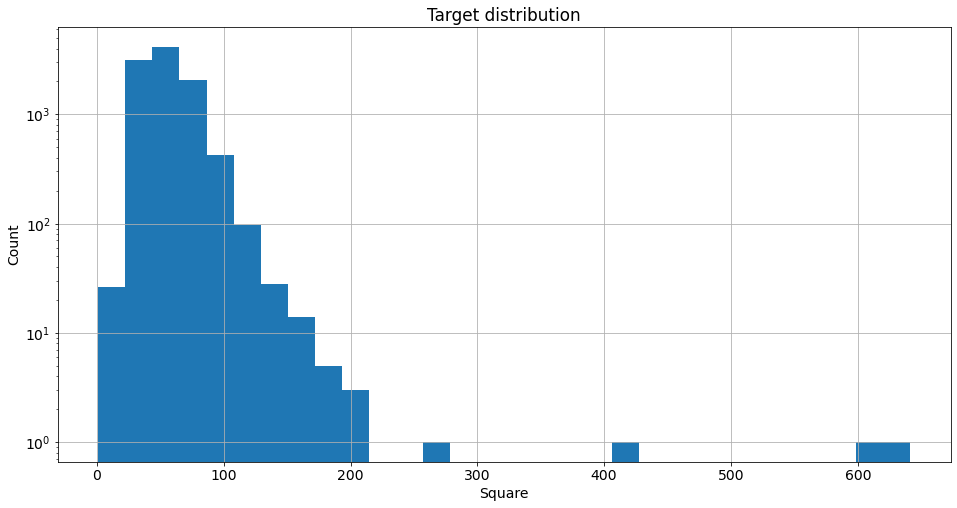

In [1234]:
plt.figure(figsize = (16, 8))

train_df['Square'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Square')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

In [1235]:
train_df[train_df['Square']>=300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,...,25,5648,1,30.0,2,4,B,187717.242538,0,0
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,26,3889,6,705.0,3,6,B,90470.430830,0,0
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,22,6398,141,1046.0,3,23,B,133529.681562,0,0


In [1713]:
train_df3[train_df3['Square']<15]

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Floor_outlier,LifeSquare_outlier,LifeSquare
161,6782,45,1.0,5.257278,1.0,1,3.0,1977,0.195781,1,...,6,1131,3,2,1,438005.182323,0,1,1,3
328,4504,27,3.0,5.610772,1.0,8,19.0,2016,0.211401,1,...,0,663,0,1,1,161379.067034,0,0,1,3
1401,9487,5,1.0,5.549458,1.0,1,1.0,1977,0.150818,1,...,4,2643,4,5,1,369472.403061,0,0,1,3
4496,15744,34,1.0,2.642219,1.0,4,21.0,1977,0.069753,1,...,4,1686,1,11,1,458378.777006,0,1,1,1
4800,7657,38,1.0,4.618547,1.0,1,28.0,1977,0.060753,1,...,2,520,0,7,1,483283.488083,0,1,1,2
5009,11526,27,1.0,4.633498,1.0,1,18.0,1977,0.011654,1,...,0,707,0,0,1,107604.269441,0,1,0,2
7470,14786,1,1.0,4.525736,1.0,1,3.0,1977,0.007122,1,...,0,396,0,1,1,181434.825589,0,1,1,2
8572,10202,6,1.0,4.604943,1.0,3,25.0,2014,0.243205,1,...,0,540,0,0,1,137597.601458,0,0,1,2
9869,3224,27,2.0,2.377248,0.0,1,17.0,1977,0.017647,1,...,0,707,0,0,1,126596.941798,0,0,0,1


In [1236]:
train_df['Square_outlier'] = 0
train_df.loc[train_df['Square'] >=300, 'Square_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.102962,0,0,0


In [1237]:
train_df.loc[train_df['Square']>=300, 'Square'] = train_df['Square'].median()

In [1238]:
train_df.loc[train_df['HouseFloor']==0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,...,629,1,NaN,0,0,A,135466.559958,0,0,0
152,12947,53,2.0,56.023342,NaN,0.0,14,0.0,1977,0.049637,...,7759,0,229.0,1,3,B,247074.564832,0,0,0
159,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,...,1437,3,NaN,0,2,B,168705.450148,0,0,0
186,12174,62,1.0,44.954880,NaN,0.0,8,0.0,1977,0.072158,...,629,1,NaN,0,0,A,133773.301722,0,0,0
229,15661,45,3.0,81.094922,NaN,0.0,15,0.0,1977,0.195781,...,5212,6,NaN,3,2,B,442472.456032,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,0.0,2,0.0,1977,0.011654,...,915,0,NaN,0,0,B,129674.841139,0,0,0
9931,15686,1,1.0,47.402412,NaN,0.0,14,0.0,1977,0.007122,...,264,0,NaN,0,1,B,174740.301224,0,0,0
9940,4711,6,1.0,41.224118,NaN,0.0,8,0.0,1977,0.243205,...,1564,0,540.0,0,0,B,125612.639104,0,0,0
9950,5383,48,3.0,98.994909,NaN,0.0,3,0.0,1977,0.041125,...,9515,5,NaN,1,10,B,418817.004446,0,0,0


In [1239]:
train_df['HouseFloor'].mode()[0]

17.0

In [1240]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor']==0, 'HouseFloor_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,NaN,0,6,B,343995.102962,0,0,0,0


In [1241]:
train_df.loc[train_df['HouseFloor']==0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [1242]:
train_df['Floor_outlier'] = 0
train_df.loc[train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index, 'Floor_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,NaN,0,0,B,305018.871089,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,NaN,0,1,B,168106.007630,0,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,NaN,0,6,B,343995.102962,0,0,0,0,0


In [1243]:
train_df[train_df['Floor_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,...,1130.0,1,5,B,186971.926566,0,0,0,0,1
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,...,NaN,3,2,B,250466.980777,0,0,0,0,1
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,...,176.0,5,5,B,366916.246494,0,0,0,0,1
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,...,540.0,0,0,B,191205.272608,0,0,0,0,1
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,...,NaN,3,9,B,410883.892020,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,...,1406.0,3,4,A,183485.284995,0,0,0,0,1
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,NaN,1,10,B,524365.550705,0,0,0,0,1
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,...,NaN,0,1,B,248248.935528,0,0,0,0,1
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,...,540.0,0,0,B,114878.830713,0,0,0,0,1


Поменяем местами значения Floor и HouseFloor:

In [1244]:
floor = train_df['Floor']
floor

0        4
1        7
2        2
3       10
4       16
        ..
9995     3
9996    13
9997     3
9998     3
9999     9
Name: Floor, Length: 10000, dtype: int64

In [1245]:
floor_df = pd.DataFrame(floor)
floor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Floor   10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [1246]:
floor_df.loc[~((floor_df.index.isin(train_df.index))&(train_df['Floor_outlier'] == 0)),:]

,Floor
17,6
19,16
21,11
25,18
26,13
...,...
9953,19
9960,15
9968,18
9970,18


In [1247]:
train_df['Floor'].where(~(train_df['Floor_outlier'] == 1), other=train_df['HouseFloor'], inplace=True)

In [1248]:
train_df['HouseFloor'].where(~(train_df['Floor_outlier'] == 1), other=floor_df['Floor'], inplace=True)

In [1249]:
train_df[train_df['Floor_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,5,6.0,1962,0.458174,...,1130.0,1,5,B,186971.926566,0,0,0,0,1
19,367,45,1.0,42.367289,40.012529,1.0,14,16.0,2015,0.195781,...,NaN,3,2,B,250466.980777,0,0,0,0,1
21,8471,20,3.0,75.611065,47.494621,8.0,9,11.0,1976,0.019509,...,176.0,5,5,B,366916.246494,0,0,0,0,1
25,4521,6,2.0,65.409965,NaN,1.0,1,18.0,1977,0.243205,...,540.0,0,0,B,191205.272608,0,0,0,0,1
26,8553,88,3.0,83.262530,4.769174,1.0,1,13.0,1977,0.127376,...,NaN,3,9,B,410883.892020,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,17,19.0,1992,0.133215,...,1406.0,3,4,A,183485.284995,0,0,0,0,1
9960,16258,48,3.0,96.056784,98.152802,1.0,1,15.0,2017,0.041125,...,NaN,1,10,B,524365.550705,0,0,0,0,1
9968,9920,1,3.0,86.487550,NaN,1.0,17,18.0,1977,0.007122,...,NaN,0,1,B,248248.935528,0,0,0,0,1
9970,13501,6,1.0,41.310416,19.117077,9.0,17,18.0,1977,0.243205,...,540.0,0,0,B,114878.830713,0,0,0,0,1


In [1250]:
train_df.loc[train_df['HouseFloor'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier


In [1251]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          7887 non-null   float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        5202 non-null   float64
 16  Helth

In [1252]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.889000,56.166010,37.199645,6.273300,7.934200,13.659200,1984.865700,0.118858,...,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.000200,0.001200,0.000300,0.026900,0.157800
std,4859.01902,43.587592,0.812247,19.149659,86.241209,28.560917,5.207397,6.017963,18.411517,0.119025,...,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.014141,0.034622,0.017319,0.161799,0.364572
min,0.00000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513040,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,...,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.889736,45.128803,9.000000,11.000000,17.000000,2001.000000,0.195781,...,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000,0.000000
max,16798.00000,209.000000,5.000000,275.645284,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000


Обработаем выбросы по LifeSquare. При LifeSquare > Square поменяем их местами.

In [1253]:
train_df['LifeSquare'].where(~(train_df['LifeSquare'] > 300), other=train_df['LifeSquare']/10, inplace=True)

In [1254]:
train_df['LifeSquare'].where(~(train_df['LifeSquare'] > 700), other=train_df['LifeSquare']/100, inplace=True)

In [1255]:
train_df.loc[train_df['LifeSquare'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier


In [1256]:
train_df['LifeSquare_outlier'] = 0
train_df.loc[train_df.loc[train_df['LifeSquare'] > train_df['Square']].index, 'LifeSquare_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,0,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,0,0,0,0,0,0


In [1257]:
train_df.loc[train_df['LifeSquare_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier
33,847,74,2.0,73.314975,74.131261,1.0,6,7.0,1977,0.075779,...,0,2,B,254005.381863,0,0,0,0,1,1
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,...,0,1,B,300180.365669,0,0,0,0,0,1
77,11771,45,1.0,38.467276,39.624493,1.0,9,11.0,1977,0.195781,...,3,2,B,247440.530601,0,0,0,0,1,1
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,...,0,2,B,226808.747168,0,0,0,0,0,1
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,...,5,5,B,199248.114376,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,1,15.0,2017,0.041125,...,1,10,B,524365.550705,0,0,0,0,1,1
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,...,3,6,B,87556.385617,0,0,0,0,0,1
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,...,0,0,B,134888.083598,0,0,0,0,0,1
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,...,0,1,B,203908.192698,0,0,0,0,0,1


In [1258]:
square = train_df['Square']
square_df = pd.DataFrame(square)
square_df = square_df.loc[~((square_df.index.isin(train_df.index))&(train_df['LifeSquare_outlier'] == 0)),:]
square_df

,Square
33,73.314975
64,87.200625
77,38.467276
100,79.937665
111,28.438794
...,...
9960,96.056784
9962,42.029175
9979,40.043234
9987,62.690057


In [1259]:
train_df['Square'].where(~(train_df['LifeSquare_outlier'] == 1), other=train_df['LifeSquare'], inplace=True)

In [1260]:
train_df['LifeSquare'].where(~(train_df['LifeSquare_outlier'] == 1), other=square_df['Square'], inplace=True)

In [1261]:
train_df.loc[train_df['LifeSquare_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier
33,847,74,2.0,74.131261,73.314975,1.0,6,7.0,1977,0.075779,...,0,2,B,254005.381863,0,0,0,0,1,1
64,3992,1,3.0,87.730225,87.200625,0.0,21,22.0,1977,0.007122,...,0,1,B,300180.365669,0,0,0,0,0,1
77,11771,45,1.0,39.624493,38.467276,1.0,9,11.0,1977,0.195781,...,3,2,B,247440.530601,0,0,0,0,1,1
100,13343,74,2.0,82.931595,79.937665,1.0,8,21.0,1977,0.075779,...,0,2,B,226808.747168,0,0,0,0,0,1
111,13875,20,1.0,32.514021,28.438794,6.0,6,10.0,2014,0.019509,...,5,5,B,199248.114376,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,98.152802,96.056784,1.0,1,15.0,2017,0.041125,...,1,10,B,524365.550705,0,0,0,0,1,1
9962,14175,14,1.0,44.682167,42.029175,10.0,4,4.0,2018,0.238617,...,3,6,B,87556.385617,0,0,0,0,0,1
9979,2201,6,1.0,41.984322,40.043234,1.0,3,17.0,2014,0.243205,...,0,0,B,134888.083598,0,0,0,0,0,1
9987,11665,1,2.0,64.602939,62.690057,10.0,19,22.0,2018,0.007122,...,0,1,B,203908.192698,0,0,0,0,0,1


In [1262]:
train_df.loc[train_df['LifeSquare'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier
15,4328,96,1.0,36.673407,16.285522,9.0,3,12.0,2003,0.041116,...,1,4,B,168143.345700,0,0,0,0,0,0
26,8553,88,3.0,83.262530,4.769174,1.0,1,13.0,1977,0.127376,...,3,9,B,410883.892020,0,0,0,0,1,0
28,1924,24,1.0,34.127059,19.435738,6.0,5,5.0,1960,0.111627,...,2,3,B,173155.770779,0,0,0,0,0,0
40,10954,119,1.0,32.994994,17.717022,5.0,4,5.0,1963,0.033494,...,3,8,B,158611.394377,0,0,0,0,0,0
56,16780,42,1.0,40.893527,18.251862,10.0,4,24.0,2007,0.158249,...,1,0,B,171531.569155,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,12778,28,1.0,37.817065,19.774407,6.0,5,9.0,1983,0.118537,...,1,0,B,168151.013690,0,0,0,0,0,0
9982,10268,27,1.0,36.112393,1.855415,1.0,9,16.0,1977,0.211401,...,0,1,B,94881.691800,0,0,0,0,0,0
9985,277,93,1.0,34.723984,19.840550,9.0,6,16.0,1988,0.521867,...,0,0,B,149649.082219,0,0,0,0,0,0
9990,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,...,3,5,B,112411.221700,0,0,0,0,0,0


In [1263]:
train_df['LifeSquare'].median()

32.75778296356265

In [1264]:
train_df['LifeSquare'].where(~(train_df['LifeSquare'] < 10), other=train_df['LifeSquare']+10, inplace=True)

In [1265]:
train_df['LifeSquare'].where(~(train_df['LifeSquare'] < 20), other=train_df['Square']*0.6, inplace=True)

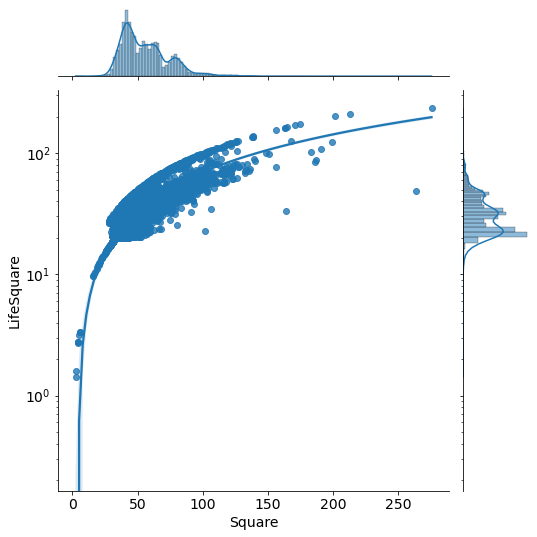

In [1266]:
grid =sns.jointplot(train_df['Square'], train_df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.yscale(value='log')
plt.show()

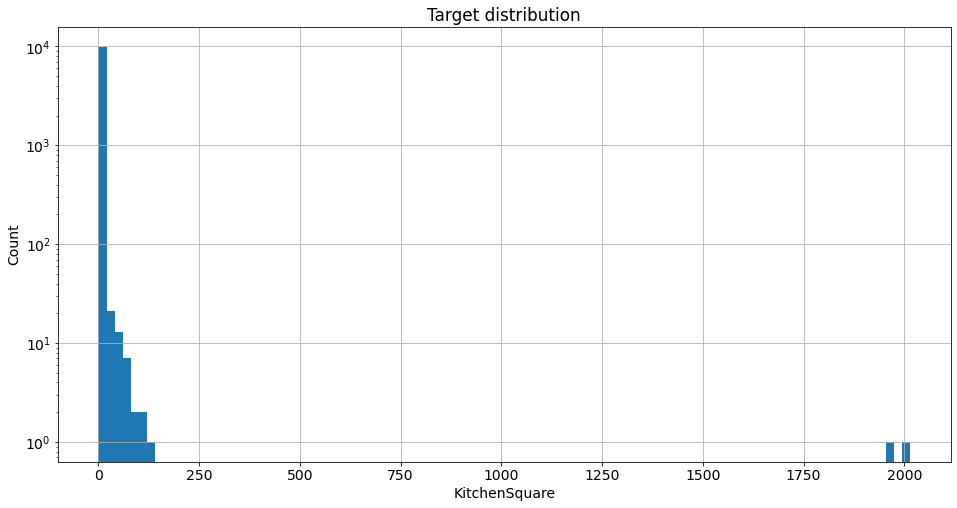

In [1267]:
plt.figure(figsize = (16, 8))

train_df['KitchenSquare'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

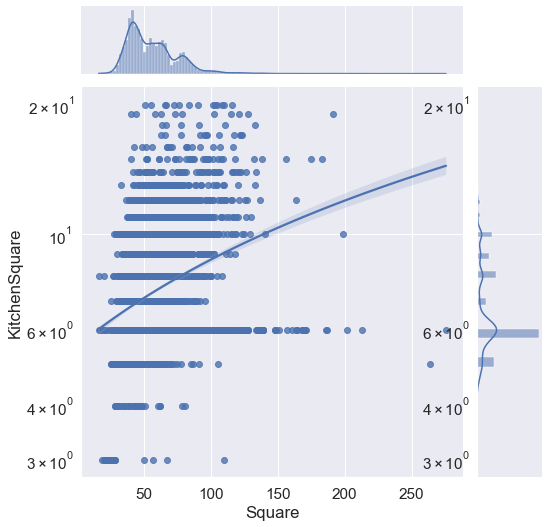

In [50]:
grid =sns.jointplot(train_df['Square'], train_df['KitchenSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.yscale(value='log')
plt.show()

In [51]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,Floor_outlier,LifeSquare_outlier
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891400,56.345130,37.139496,7.325500,7.934200,13.659200,1984.865700,0.118858,0.990300,...,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399,0.000200,0.157800,0.047100
std,43.587592,0.838735,19.217349,16.571908,2.166661,5.207397,6.017963,18.411517,0.119025,0.098015,...,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865,0.014141,0.364572,0.211863
min,0.000000,1.000000,16.117154,9.670293,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.888816,24.222081,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,...,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942,0.000000,0.000000,0.000000
50%,36.000000,2.000000,52.714760,33.129753,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,...,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879,0.000000,0.000000,0.000000
75%,75.000000,2.000000,65.986649,45.219881,9.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,...,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171,0.000000,0.000000,0.000000
max,209.000000,17.000000,275.645284,233.949309,20.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,1.000000,1.000000,1.000000


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  int64  
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          7887 non-null   float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  int64  
 11  Ecology_3           10000 non-null  int64  
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        5202 non-null   float64
 16  Helth

In [1271]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[train_df['KitchenSquare'] > 20, 'KitchenSquare_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier,KitchenSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,B,305018.871089,0,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,B,177734.553407,0,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,B,282078.720850,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,B,168106.007630,0,0,0,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,B,343995.102962,0,0,0,0,0,0,0


In [1272]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [1273]:
train_df.loc[train_df['KitchenSquare']>20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier,KitchenSquare_outlier
277,13559,79,1.0,96.838013,49.140960,22.0,19,24.0,2016,0.050756,...,1,B,348962.861294,0,0,0,0,0,0,1
286,2737,27,3.0,125.806981,123.430072,123.0,5,10.0,2015,0.017647,...,0,B,234194.837047,0,0,0,0,0,1,1
456,10546,62,1.0,46.013187,43.417043,43.0,4,17.0,2019,0.072158,...,0,A,113909.099428,0,0,0,0,0,0,1
511,8685,62,5.0,124.933289,81.122369,30.0,3,5.0,2017,0.072158,...,0,A,271919.866048,0,0,0,0,1,0,1
682,16593,52,2.0,64.859242,NaN,62.0,15,17.0,1977,0.371149,...,5,B,185993.474671,0,0,0,0,0,0,1
755,15781,10,1.0,35.813564,21.488139,35.0,6,14.0,1971,0.282798,...,6,B,164306.314182,0,0,0,0,0,0,1
1614,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,...,5,B,169528.896664,0,0,0,0,0,0,1
1728,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,...,9,B,370148.625285,0,0,0,0,0,0,1
1776,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,2013,0.041116,...,4,B,528560.506016,0,0,0,0,0,1,1
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,7,B,455264.882666,0,0,0,0,0,0,1


In [1274]:
train_df.loc[train_df['KitchenSquare']>20, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [1275]:
train_df['KitchenSquare'].value_counts()

1.0     2460
8.0     1306
5.0     1169
6.0     1086
10.0    1075
9.0      843
0.0      697
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
3.0       22
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
2.0        4
Name: KitchenSquare, dtype: int64

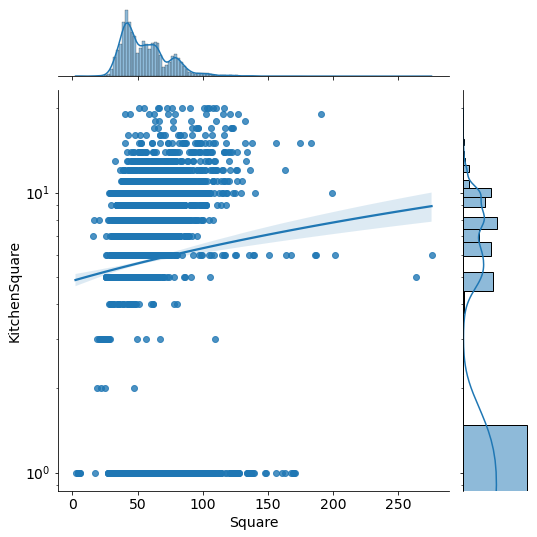

In [1276]:
grid =sns.jointplot(train_df['Square'], train_df['KitchenSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.yscale(value='log')
plt.show()

In [1277]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,HouseYear_outlier,Rooms_outlier,Square_outlier,HouseFloor_outlier,Floor_outlier,LifeSquare_outlier,KitchenSquare_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.889000,56.296497,37.099153,5.675700,7.934200,13.659200,1984.865700,0.118858,...,1.319500,4.231300,214138.857399,0.000200,0.001200,0.000300,0.026900,0.157800,0.048000,0.004800
std,4859.01902,43.587592,0.812247,19.284874,16.613655,3.874639,5.207397,6.017963,18.411517,0.119025,...,1.493601,4.806341,92872.293865,0.014141,0.034622,0.017319,0.161799,0.364572,0.213777,0.069119
min,0.00000,0.000000,1.000000,2.377248,1.426349,0.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.866858,24.180721,1.000000,4.000000,9.000000,1974.000000,0.017647,...,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.619610,33.129655,6.000000,7.000000,14.000000,1977.000000,0.075424,...,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.986649,45.211134,9.000000,11.000000,17.000000,2001.000000,0.195781,...,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16798.00000,209.000000,5.000000,275.645284,233.949309,20.000000,42.000000,117.000000,2020.000000,0.521867,...,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


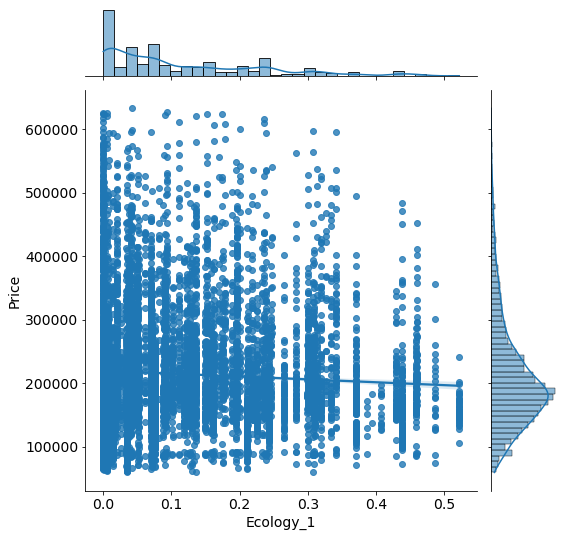

In [1278]:
grid =sns.jointplot(train_df['Ecology_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

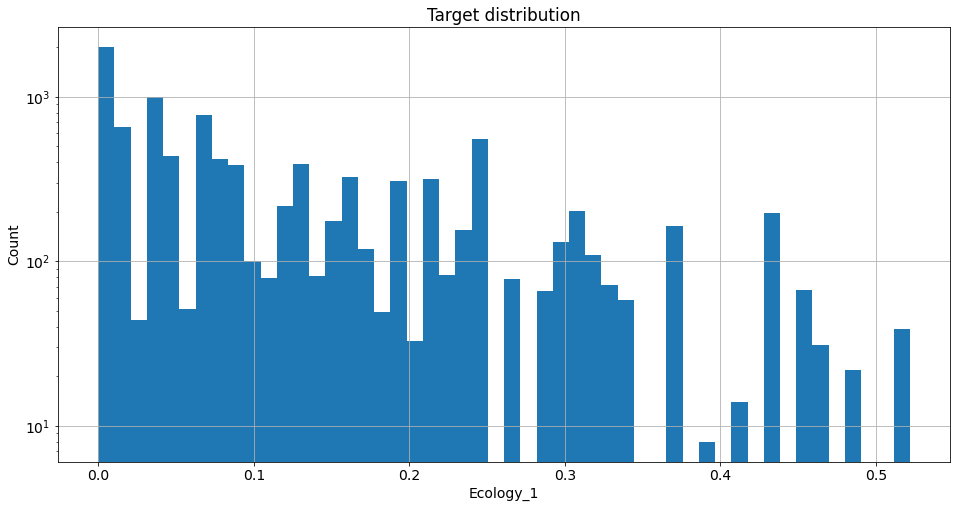

In [1279]:
plt.figure(figsize = (16, 8))

train_df['Ecology_1'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Ecology_1')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

In [1283]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  int64  
 1   DistrictId             10000 non-null  int64  
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             7887 non-null   float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  int64  
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  object 
 11  Ecology_3              10000 non-null  object 
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

In [42]:
train_df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
train_df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
train_df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

In [43]:
test_df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
test_df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
test_df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

In [44]:
train_df.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_outlier,0,nan
0,11809,27,3.0,115.027311,10.0,4,10.0,2014,0.075424,1,...,3097,0,NaN,0,0,1,305018.871089,0,0,1
1,3013,22,1.0,39.832524,8.0,7,8.0,1966,0.118537,1,...,6207,1,1183.0,1,0,1,177734.553407,0,1,0
2,8215,1,3.0,78.342215,10.0,2,17.0,1988,0.025609,1,...,5261,0,240.0,3,1,1,282078.720850,0,2,0
3,2352,1,1.0,40.409907,1.0,10,22.0,1977,0.007122,1,...,264,0,NaN,0,1,1,168106.007630,0,3,1
4,13866,94,2.0,64.285067,9.0,16,16.0,1972,0.282798,1,...,8667,2,NaN,0,6,1,343995.102962,0,4,1


Предскажем пропущенные значения Healthcare_1 и LifeSquare на train_df

In [344]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
train_df['0'] = [x for x in range(len(train_df))]
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,0
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,1,305018.871089,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,0,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,0,0,2
3,2352,1,1.0,40.409907,NaN,6.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,1,168106.007630,0,0,3
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,1,343995.102962,0,0,4


In [345]:
df_drop = train_df[['LifeSquare', '0']]

In [346]:
df_drop.head()

,LifeSquare,0
0,NaN,0
1,23.169223,1
2,47.671972,2
3,NaN,3
4,38.562517,4


In [347]:
w = [x for x in train_df['LifeSquare']]

In [348]:
target_name = 'Healthcare_1'
train_df.drop(['LifeSquare'], axis=1, inplace=True)

In [349]:
train_df['nan'] = 0
train_df.loc[train_df[target_name].isna(), 'nan'] = 1

In [350]:
df_test = train_df[train_df['nan'] == 1]
df_train = train_df[train_df['nan'] == 0]

In [351]:
target_name = 'Healthcare_1'
df_train[target_name] = df_train[target_name].apply(int)
df_train = df_train.drop(columns='nan')

In [352]:
X = df_train.drop(columns=[target_name, '0'])
y = df_train[target_name]

Train R2:	1.0
Test R2:	0.996


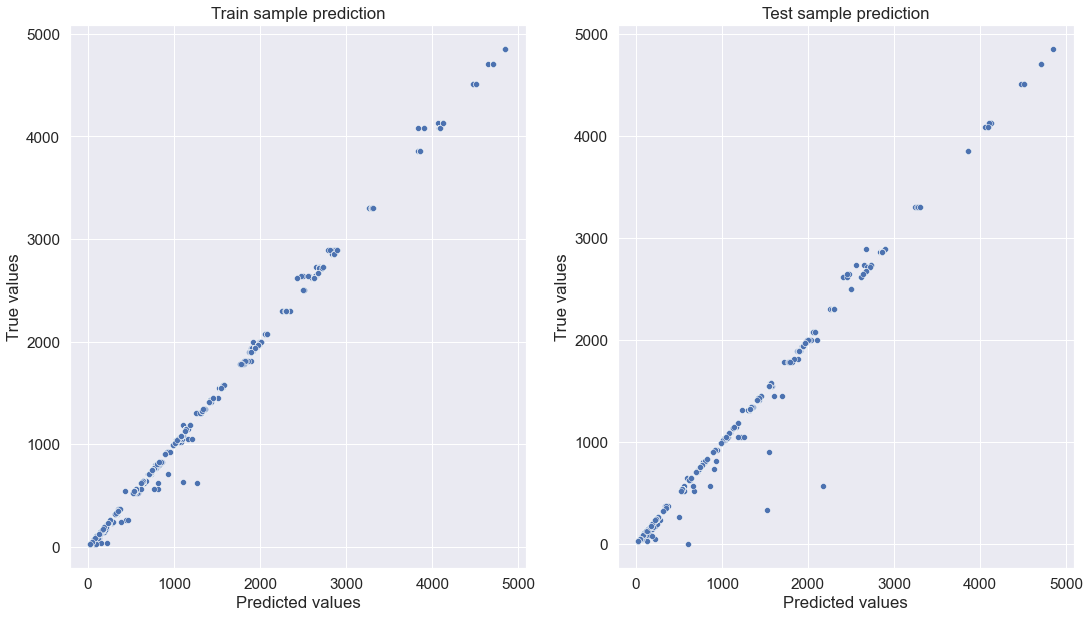

In [353]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [354]:
v = [x for x in df_test['0']]
df_test = df_test.drop(columns=[target_name, '0'])
df_test = df_test.drop(columns='nan')

In [355]:
df_test[target_name] = rf_model.predict(df_test)

In [356]:
df_test[target_name] = df_test[target_name].apply(int)

In [357]:
df_test['0'] = v

In [358]:
df_test.head(10)

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,Healthcare_1,0
0,11809,27,3.0,115.027311,10.0,4,10.0,2014,0.075424,1,...,3097,0,0,0,1,305018.871089,0,0,805,0
3,2352,1,1.0,40.409907,6.0,10,22.0,1977,0.007122,1,...,264,0,0,1,1,168106.007630,0,0,341,3
4,13866,94,2.0,64.285067,9.0,16,16.0,1972,0.282798,1,...,8667,2,0,6,1,343995.102962,0,0,2100,4
8,9951,1,1.0,46.887892,6.0,12,20.0,1977,0.007122,1,...,264,0,0,1,1,160400.401732,0,0,341,8
11,16755,88,2.0,53.975144,8.0,2,12.0,1978,0.127376,1,...,8429,3,3,9,1,253124.005332,0,0,1977,11
14,191,36,3.0,81.994790,10.0,2,22.0,2008,0.087619,1,...,1497,5,1,0,1,481360.360728,0,0,1111,14
15,4328,96,1.0,36.673407,9.0,3,12.0,2003,0.041116,1,...,14892,4,1,4,1,168143.345700,0,0,1869,15
16,11942,48,1.0,44.825250,8.0,7,12.0,1981,0.041125,1,...,9515,5,1,10,1,207633.660287,0,0,1698,16
18,4581,1,1.0,47.582480,6.0,16,16.0,1977,0.007122,1,...,264,0,0,1,1,128803.593810,0,0,341,18
19,367,45,1.0,42.367289,6.0,14,16.0,2015,0.195781,1,...,5212,6,3,2,1,250466.980777,1,0,1067,19


In [359]:
train_df2 = pd.concat([df_train, df_test]) 
train_df2.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,0
1,3013,22,1.0,39.832524,8.0,7,8.0,1966,0.118537,1,...,6207,1,1183,1,0,1,177734.553407,0,0,1
2,8215,1,3.0,78.342215,10.0,2,17.0,1988,0.025609,1,...,5261,0,240,3,1,1,282078.720850,0,0,2
5,5804,99,3.0,62.528465,6.0,9,9.0,1972,0.012339,1,...,5776,1,2078,2,4,1,161044.944138,0,0,5
6,8864,44,1.0,33.938750,9.0,1,12.0,1968,0.232205,1,...,4860,1,80,0,3,1,142402.739272,0,0,6
7,13072,59,2.0,50.391814,8.0,8,17.0,1986,0.019509,1,...,7687,11,176,5,5,1,326174.175191,0,0,7


In [360]:
train_df2 = train_df2.sort_values(by=['0'])

In [361]:
train_df2 = train_df2.merge(df_drop, left_on='0', right_on='0', how='left')

In [362]:
train_df2.head().T

,0,1,2,3,4
Id,11809,3013,8215,2352,13866
DistrictId,27,22,1,1,94
Rooms,3.0,1.0,3.0,1.0,2.0
Square,115.027311,39.832524,78.342215,40.409907,64.285067
KitchenSquare,10.0,8.0,10.0,6.0,9.0
Floor,4,7,2,10,16
HouseFloor,10.0,8.0,17.0,22.0,16.0
HouseYear,2014,1966,1988,1977,1972
Ecology_1,0.075424,0.118537,0.025609,0.007122,0.282798
Ecology_2,1,1,1,1,1


Предскажем пропущенные значения LifeSquare

In [363]:
target_name = 'LifeSquare'

In [364]:
train_df2['nan'] = 0
train_df2.loc[train_df2[target_name].isna(), 'nan'] = 1

In [365]:
train_df2.loc[train_df2['nan'] == 1]

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,0,LifeSquare,nan
0,11809,27,3.0,115.027311,10.0,4,10.0,2014,0.075424,1,...,805,0,0,1,305018.871089,0,0,0,NaN,1
3,2352,1,1.0,40.409907,6.0,10,22.0,1977,0.007122,1,...,341,0,1,1,168106.007630,0,0,3,NaN,1
18,4581,1,1.0,47.582480,6.0,16,16.0,1977,0.007122,1,...,341,0,1,1,128803.593810,0,0,18,NaN,1
20,8768,63,1.0,50.974891,6.0,7,16.0,2018,0.238617,1,...,705,3,6,1,260328.413376,0,0,20,NaN,1
24,4717,27,1.0,44.203947,6.0,2,17.0,1977,0.072158,1,...,486,0,0,0,135466.559958,0,0,24,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,6.0,17,18.0,1977,0.243205,1,...,540,0,0,1,154366.031184,1,0,9975,NaN,1
9978,4851,1,1.0,39.314342,6.0,13,17.0,1977,0.007122,1,...,341,0,1,1,137782.941940,0,0,9978,NaN,1
9981,6753,62,2.0,73.092686,6.0,4,16.0,2017,0.072158,1,...,493,0,0,0,159077.198056,0,0,9981,NaN,1
9983,647,1,2.0,63.324025,6.0,4,17.0,1977,0.007122,1,...,343,0,1,1,183809.327114,0,0,9983,NaN,1


In [366]:
df_test2 = train_df2[train_df2['nan'] == 1]
df_train2 = train_df2[train_df2['nan'] == 0]

In [367]:
target_name = 'LifeSquare'
df_train2[target_name] = df_train2[target_name].apply(int)
df_train2 = df_train2.drop(columns='nan')

In [368]:
X = df_train2.drop(columns=[target_name, '0'])
y = df_train2[target_name]

Train R2:	0.978
Test R2:	0.857


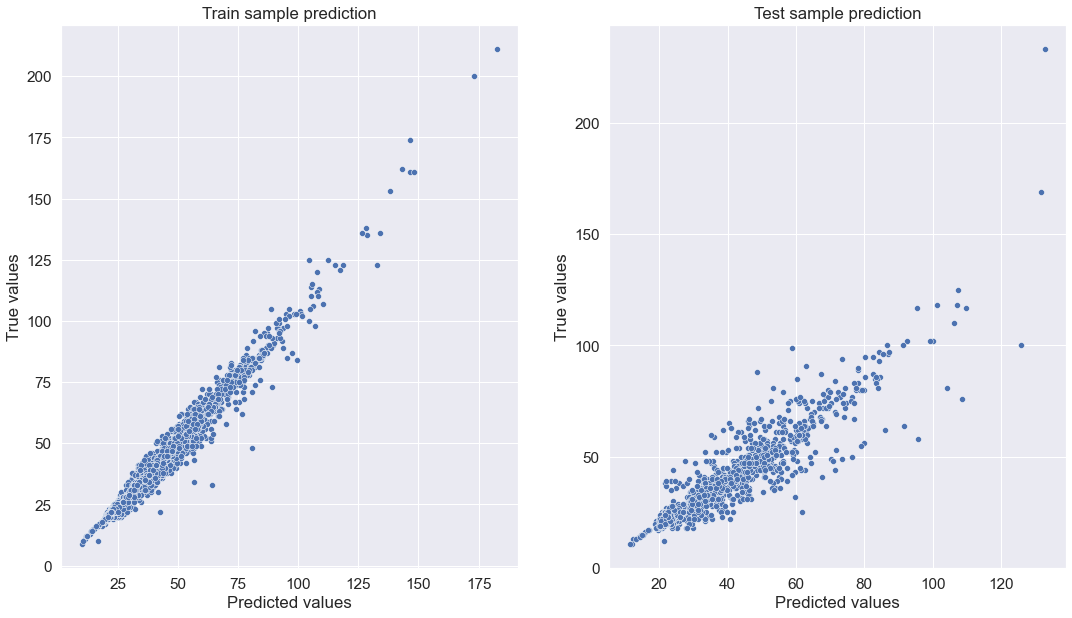

In [369]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [370]:
v = [x for x in df_test['0']]
df_test2 = df_test2.drop(columns=[target_name, '0'])
df_test2 = df_test2.drop(columns='nan')

In [371]:
df_test2[target_name] = rf_model.predict(df_test2)

In [372]:
df_test2[target_name] = df_test2[target_name].apply(int)

In [373]:
df_test['0'] = v

In [374]:
train_df3 = pd.concat([df_train2, df_test2]) 
train_df3.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,0,LifeSquare
1,3013,22,1.0,39.832524,8.0,7,8.0,1966,0.118537,1,...,1,1183,1,0,1,177734.553407,0,0,1.0,23
2,8215,1,3.0,78.342215,10.0,2,17.0,1988,0.025609,1,...,0,240,3,1,1,282078.720850,0,0,2.0,47
4,13866,94,2.0,64.285067,9.0,16,16.0,1972,0.282798,1,...,2,2100,0,6,1,343995.102962,0,0,4.0,38
5,5804,99,3.0,62.528465,6.0,9,9.0,1972,0.012339,1,...,1,2078,2,4,1,161044.944138,0,0,5.0,47
6,8864,44,1.0,33.938750,9.0,1,12.0,1968,0.232205,1,...,1,80,0,3,1,142402.739272,0,0,6.0,21


In [375]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   KitchenSquare       10000 non-null  float64
 5   Floor               10000 non-null  int64  
 6   HouseFloor          10000 non-null  float64
 7   HouseYear           10000 non-null  int64  
 8   Ecology_1           10000 non-null  float64
 9   Ecology_2           10000 non-null  int64  
 10  Ecology_3           10000 non-null  int64  
 11  Social_1            10000 non-null  int64  
 12  Social_2            10000 non-null  int64  
 13  Social_3            10000 non-null  int64  
 14  Healthcare_1        5202 non-null   float64
 15  Helthcare_2         10000 non-null  int64  
 16  Shops

In [376]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 9991
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   KitchenSquare       10000 non-null  float64
 5   Floor               10000 non-null  int64  
 6   HouseFloor          10000 non-null  float64
 7   HouseYear           10000 non-null  int64  
 8   Ecology_1           10000 non-null  float64
 9   Ecology_2           10000 non-null  int64  
 10  Ecology_3           10000 non-null  int64  
 11  Social_1            10000 non-null  int64  
 12  Social_2            10000 non-null  int64  
 13  Social_3            10000 non-null  int64  
 14  Healthcare_1        10000 non-null  int64  
 15  Helthcare_2         10000 non-null  int64  
 16  Shops

In [377]:
train_df3 = train_df3.drop(columns='0')

In [378]:
train_df3['DistrictId'] = train_df3['DistrictId'].astype(int)

Предскажем пропущенные значения на test_train:

In [379]:
test_df['0'] = [x for x in range(len(test_df))]

In [380]:
df_drop_test = test_df[['LifeSquare', '0']]

In [381]:
target_name = 'Healthcare_1'
test_df.drop(['LifeSquare'], axis=1, inplace=True)

In [382]:
test_df['nan'] = 0
test_df.loc[test_df[target_name].isna(), 'nan'] = 1

In [383]:
df_test_test = test_df[test_df['nan'] == 1]
df_train_test = test_df[test_df['nan'] == 0]

In [384]:
target_name = 'Healthcare_1'
df_train_test[target_name] = df_train_test[target_name].apply(int)
df_train_test = df_train_test.drop(columns='nan')

In [385]:
X = df_train_test.drop(columns=[target_name, '0'])
y = df_train_test[target_name]

Train R2:	0.999
Test R2:	0.991


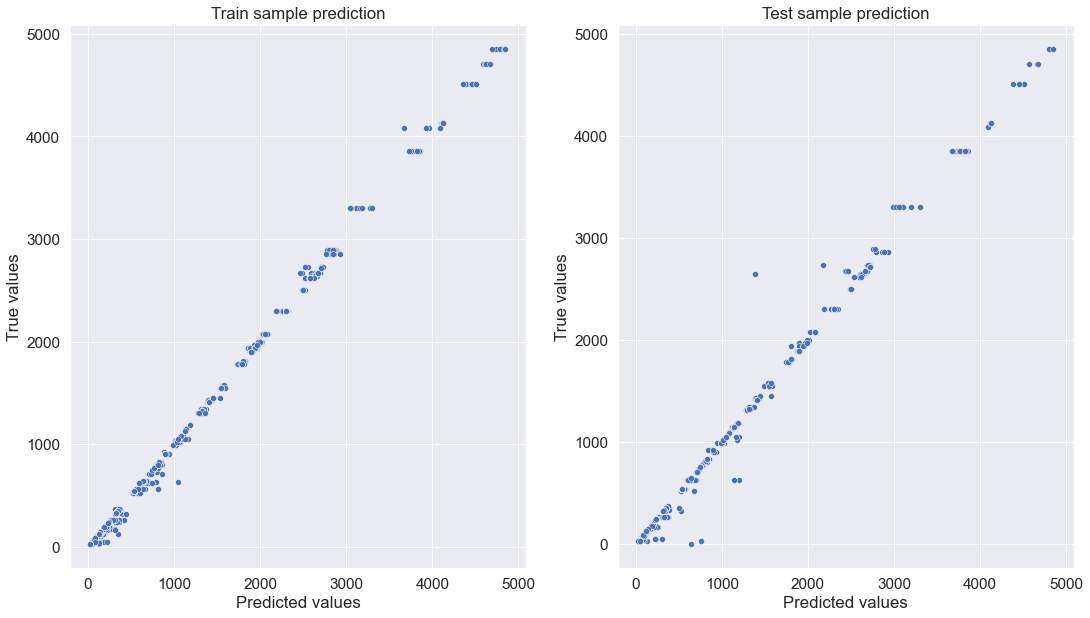

In [386]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [387]:
v = [x for x in df_test_test['0']]
df_test_test = df_test_test.drop(columns=[target_name, '0'])
df_test_test = df_test_test.drop(columns='nan')

In [388]:
df_test_test[target_name] = rf_model.predict(df_test_test)

In [389]:
df_test_test[target_name] = df_test_test[target_name].apply(int)

In [390]:
df_test_test['0'] = v

In [391]:
test_df2 = pd.concat([df_train_test, df_test_test]) 

In [392]:
test_df2 = test_df2.sort_values(by=['0'])

In [393]:
test_df2 = test_df2.merge(df_drop_test, left_on='0', right_on='0', how='left')

In [394]:
target_name = 'LifeSquare'

In [395]:
test_df2['nan'] = 0
test_df2.loc[test_df2[target_name].isna(), 'nan'] = 1

In [396]:
df_test_test2 = test_df2[test_df2['nan'] == 1]
df_train_test2 = test_df2[test_df2['nan'] == 0]

In [397]:
df_train_test2[target_name] = df_train_test2[target_name].apply(int)
df_train_test2 = df_train_test2.drop(columns='nan')

In [398]:
X = df_train_test2.drop(columns=[target_name, '0'])
y = df_train_test2[target_name]

Train R2:	0.978
Test R2:	0.867


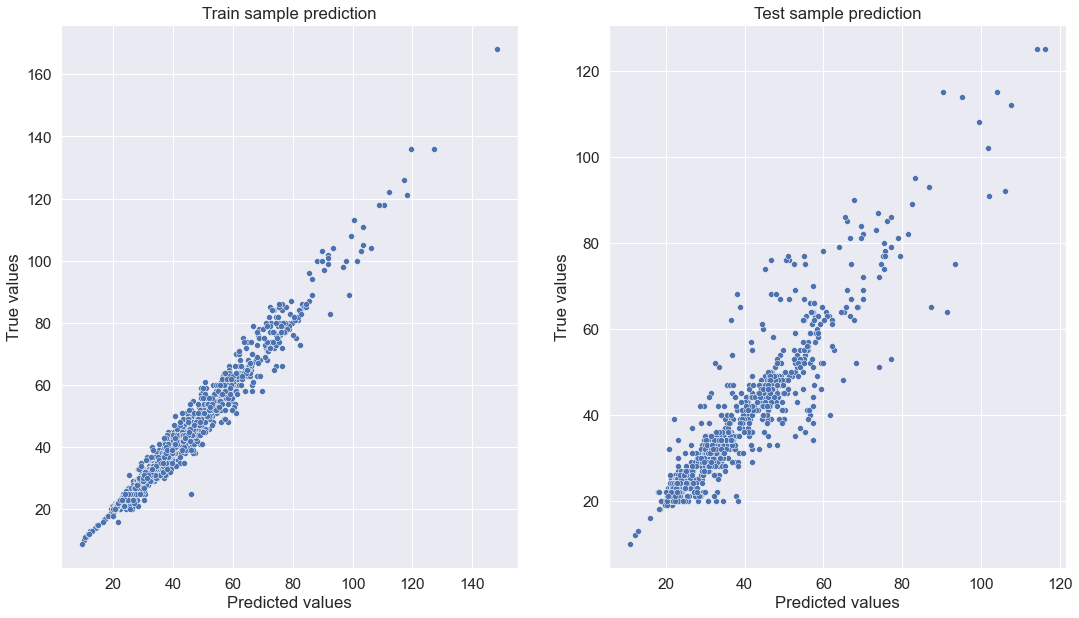

In [399]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [400]:
v = [x for x in df_test_test['0']]
df_test_test2 = df_test_test2.drop(columns=[target_name, '0'])
df_test_test2 = df_test_test2.drop(columns='nan')

In [401]:
df_test_test2[target_name] = rf_model.predict(df_test_test2)

In [402]:
df_test_test2[target_name] = df_test_test2[target_name].apply(int)

In [403]:
df_test_test['0'] = v

In [404]:
test_df3 = pd.concat([df_train_test2, df_test_test2]) 
train_df3.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,LifeSquare
1,3013,22,1.0,39.832524,8.0,7,8.0,1966,0.118537,1,...,6207,1,1183,1,0,1,177734.553407,0,0,23
2,8215,1,3.0,78.342215,10.0,2,17.0,1988,0.025609,1,...,5261,0,240,3,1,1,282078.720850,0,0,47
4,13866,94,2.0,64.285067,9.0,16,16.0,1972,0.282798,1,...,8667,2,2100,0,6,1,343995.102962,0,0,38
5,5804,99,3.0,62.528465,6.0,9,9.0,1972,0.012339,1,...,5776,1,2078,2,4,1,161044.944138,0,0,47
6,8864,44,1.0,33.938750,9.0,1,12.0,1968,0.232205,1,...,4860,1,80,0,3,1,142402.739272,0,0,21


In [405]:
train_df3.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,LifeSquare
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.891400,56.345130,7.325500,7.934200,13.659200,1984.865700,0.118858,0.990300,0.972500,...,5352.157400,8.039200,1081.679300,1.319500,4.231300,0.917500,214138.857399,0.157800,0.047100,38.969400
std,43.587592,0.838735,19.217349,2.166661,5.207397,6.017963,18.411517,0.119025,0.098015,0.163543,...,4006.799803,23.831875,844.069837,1.493601,4.806341,0.275139,92872.293865,0.364572,0.211863,17.425689
min,0.000000,1.000000,16.117154,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,9.000000
25%,20.000000,1.000000,41.888816,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,1564.000000,0.000000,498.000000,0.000000,1.000000,1.000000,153872.633942,0.000000,0.000000,26.000000
50%,36.000000,2.000000,52.714760,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,5285.000000,2.000000,815.000000,1.000000,3.000000,1.000000,192269.644879,0.000000,0.000000,34.000000
75%,75.000000,2.000000,65.986649,9.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,7227.000000,5.000000,1513.000000,2.000000,6.000000,1.000000,249135.462171,0.000000,0.000000,47.000000
max,209.000000,17.000000,275.645284,20.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,1.000000,1.000000,233.000000


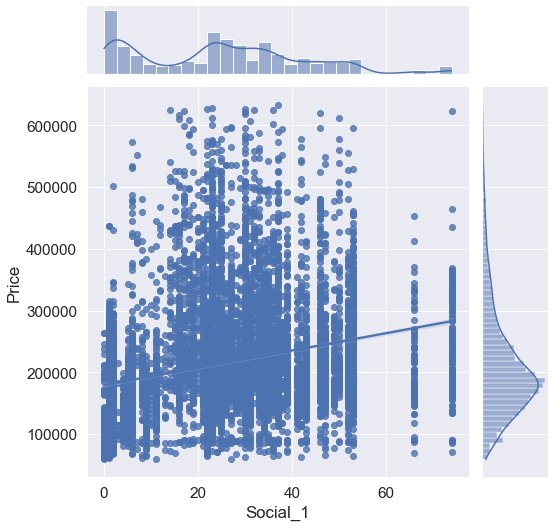

In [406]:
grid =sns.jointplot(train_df3['Social_1'], train_df3['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [407]:
train_df3.loc[train_df3['Social_3']>100, 'Social_3'] = train_df3['Social_3'].median()

In [408]:
soc = train_df3.loc[train_df3['Price']<100000]

In [409]:
soc

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_outlier,LifeSquare_outlier,LifeSquare
29,5273,23,2.0,53.199650,9.0,3,3.0,2019,0.005767,1,...,388,0,593,0,0,1,94061.943579,0,0,32
49,5474,111,2.0,63.791064,10.0,16,22.0,2006,0.093443,1,...,4635,5,3300,2,4,1,91594.315538,0,0,40
86,10807,120,3.0,58.964245,6.0,6,9.0,1976,0.341072,1,...,5664,48,2300,3,11,1,86480.956223,0,0,39
183,2457,138,1.0,34.148187,5.0,9,9.0,1962,0.014423,1,...,3806,4,538,0,3,1,86647.803371,0,0,24
190,4617,27,1.0,40.787698,10.0,8,19.0,2019,0.211401,1,...,1892,0,762,0,1,1,96245.516146,0,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,15695,23,1.0,34.205547,6.0,4,12.0,1977,0.034656,1,...,168,0,602,0,0,1,80497.861834,0,0,29
9614,1334,23,1.0,29.401008,6.0,4,17.0,2019,0.034656,1,...,168,0,601,0,0,1,71690.969474,0,0,30
9619,3166,27,1.0,41.804030,6.0,15,18.0,1977,0.211401,1,...,1892,0,762,0,1,1,97206.026618,0,0,35
9754,14696,23,2.0,57.657176,6.0,3,3.0,1977,0.005767,1,...,388,0,594,0,0,1,93493.642802,0,0,50


In [410]:
soc['Healthcare_1'].value_counts()

602     66
762     48
601     45
594     42
1046    24
        ..
1937     1
1425     1
609      1
1349     1
533      1
Name: Healthcare_1, Length: 132, dtype: int64

In [411]:
a = train_df.loc[train_df['DistrictId'].isin([179,  86,  23,  14,  10,   8,   7,   6,   5,   4,   3,   2,   1])]

In [412]:
a = train_df.loc[train_df['Price']>100000]

In [413]:
a['Shops_1'].value_counts()

0     2082
5     1281
1     1247
2      935
4      821
3      696
6      464
11     392
9      307
7      283
8      242
23     221
10     214
15     171
16      81
19      48
Name: Shops_1, dtype: int64

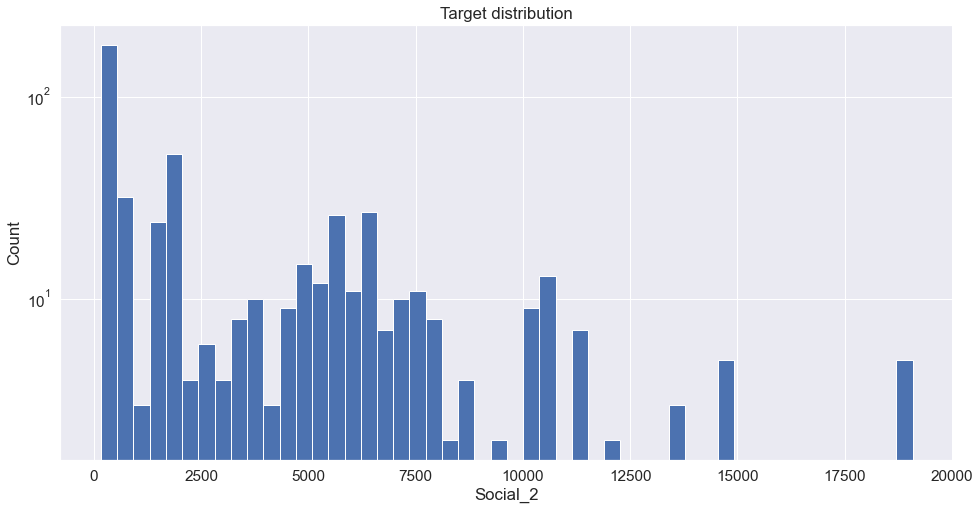

In [414]:
plt.figure(figsize = (16, 8))

soc['Social_2'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Social_2')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

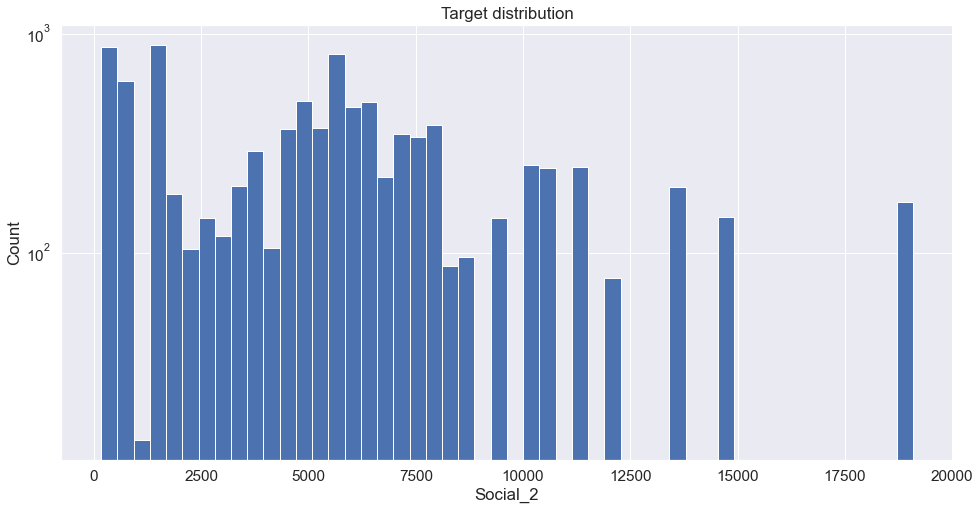

In [415]:
plt.figure(figsize = (16, 8))

a['Social_2'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Social_2')
plt.yscale(value='log')
plt.title('Target distribution')
plt.show()

In [545]:
def floor_to_cat(X):

    X['floor_cat'] = 0
    X.loc[(X['Floor'] <= 3), 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 10), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 10) & (X['Floor'] <= 20), 'floor_cat'] = 4
    X.loc[(X['Floor'] > 20), 'floor_cat'] = 5

    return X


def housing_age(X):
    X['housing_median_age'] = now.year - X['HouseYear']
    
    return X


def year_1977_cat(X):
    X['year_1977'] = 0
    X.loc[(X['HouseYear'] == 1977), 'year_1977'] = 1 
    
    return X

def districtid_cat(X):
    X['districtid_cat'] = 0
    X.loc[(X['DistrictId'].isin([179,  86,  23,  14,  10,   8,   7,   6,   5,   4,   3,   2,   1])), 'districtid_cat'] = 1 

    return X
    
    

def age_to_cat(X):

    X['age_cat'] = 0
    X.loc[(X['housing_median_age'] <= 5), 'age_cat'] = 1  
    X.loc[(X['housing_median_age'] > 5) & (X['housing_median_age'] <= 10), 'age_cat'] = 2    
    X.loc[(X['housing_median_age'] > 10) & (X['housing_median_age'] <= 25), 'age_cat'] = 3   
    X.loc[(X['housing_median_age'] > 25) & (X['housing_median_age'] <= 35), 'age_cat'] = 4   
    X.loc[(X['housing_median_age'] > 35) & (X['housing_median_age'] <= 65), 'age_cat'] = 5  
    X.loc[(X['housing_median_age'] > 75), 'age_cat'] = 6
    
    return X

def ecology1_to_cat(X):

    X['ecology1_cat'] = 0
    X.loc[(X['Ecology_1'] <= 0.05), 'ecology1_cat'] = 1  
    X.loc[(X['Ecology_1'] > 0.05) & (X['Ecology_1'] <= 0.15), 'ecology1_cat'] = 2    
    X.loc[(X['Ecology_1'] > 0.15) & (X['Ecology_1'] <= 0.25), 'ecology1_cat'] = 3   
    X.loc[(X['Ecology_1'] > 0.25) & (X['Ecology_1'] <= 0.35), 'ecology1_cat'] = 4   
    X.loc[(X['Ecology_1'] > 0.35) & (X['Ecology_1'] <= 0.45), 'ecology1_cat'] = 5  
    X.loc[(X['Ecology_1'] > 0.45), 'ecology1_cat'] = 6
    
    return X



In [546]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [547]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
preprocessor.fit(test_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [548]:
train_df['Healthcare_1'] = train_df3['Healthcare_1']
train_df['LifeSquare'] = train_df3['LifeSquare']

test_df['Healthcare_1'] = test_df3['Healthcare_1']
test_df['LifeSquare'] = test_df3['LifeSquare']

In [549]:
target_name = 'Price'

In [550]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [551]:
X_train.shape, X_valid.shape, test_df.shape

((7500, 21), (2500, 21), (5000, 21))

In [552]:
X_train = floor_to_cat(X_train)
X_train = housing_age(X_train)
X_train = ecology1_to_cat(X_train)
X_train = age_to_cat(X_train)
X_train = districtid_cat(X_train)
X_train = year_1977_cat(X_train)




X_valid = floor_to_cat(X_valid)
X_valid = housing_age(X_valid)
X_valid = ecology1_to_cat(X_valid)
X_valid = age_to_cat(X_valid)
X_valid = districtid_cat(X_valid)
X_valid = year_1977_cat(X_valid)




test_df = floor_to_cat(test_df)
test_df = housing_age(test_df)
test_df = ecology1_to_cat(test_df)
test_df = age_to_cat(test_df)
test_df = districtid_cat(test_df)
test_df = year_1977_cat(test_df)



In [553]:
rf_model = RandomForestRegressor(random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [554]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

Train R2:	0.96
Test R2:	0.745


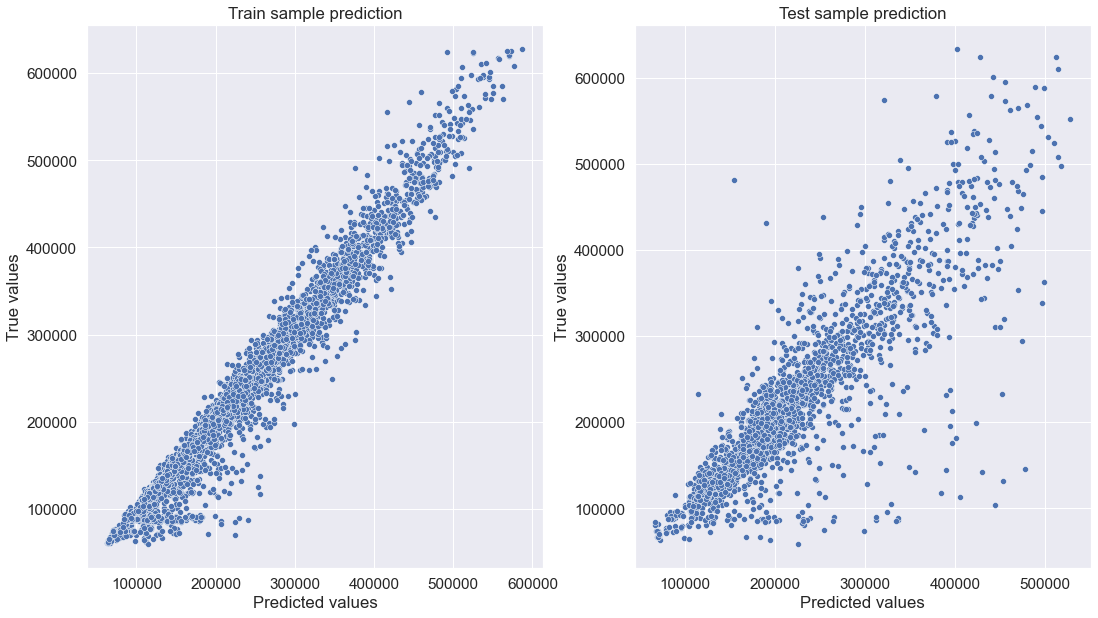

In [555]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [556]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.71234056, 0.68871922, 0.71739796, 0.71417586, 0.71332293])

In [557]:
cv_score.mean()

0.709191306755001

In [558]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.379021
12,Social_1,0.109066
13,Social_2,0.082391
2,Rooms,0.080400
14,Social_3,0.047512
1,DistrictId,0.042181
15,Healthcare_1,0.035369
9,Ecology_1,0.033927
7,HouseFloor,0.026206
0,Id,0.024956


Train R2:	0.883
Test R2:	0.777


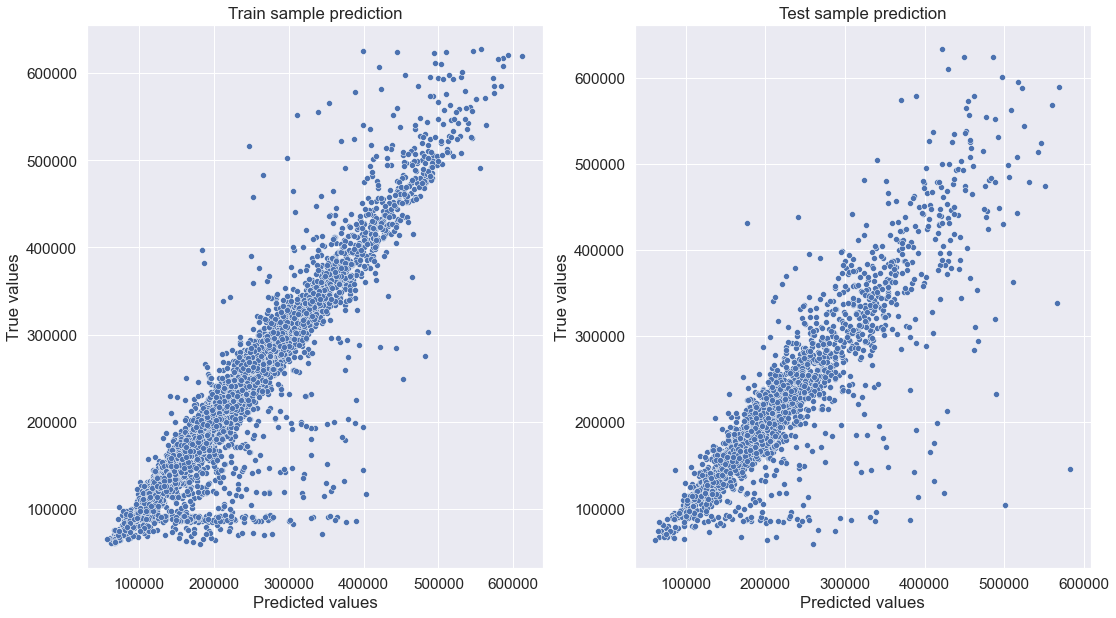

In [559]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=8,
                                     min_samples_leaf=40,
                                     random_state=21,  
                                     n_estimators=2000, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)


y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [449]:
params = {'n_estimators':[1000, 1500, 2000, 2250], 
          'max_depth':[7, 8, 9, 10],  
          'min_samples_leaf': [40, 50, 60]}
gs = GridSearchCV(gb_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=5,   
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 learning_rate=0.025,
                                                 loss='huber', max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=40,
                                                 n_estimators=2000,
                                                 random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_samples_leaf': [40, 50, 60],
                         'n_estimators': [1000, 1500, 2000, 2250]},
             scoring='r2')

In [450]:
res = pd.DataFrame(gs.cv_results_)

In [451]:
gs.best_params_

{'max_depth': 8, 'min_samples_leaf': 60, 'n_estimators': 1500}

In [452]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,31.423561,0.167800,0.063735,0.003925,7,40,1000,"{'max_depth': 7, 'min_samples_leaf': 40, 'n_es...",0.750061,0.733591,0.736156,0.756588,0.750463,0.745372,0.008916,14
1,44.523271,0.345300,0.090929,0.000347,7,40,1500,"{'max_depth': 7, 'min_samples_leaf': 40, 'n_es...",0.752567,0.731266,0.736269,0.757383,0.750107,0.745518,0.010002,10
2,57.625900,0.310664,0.120626,0.005794,7,40,2000,"{'max_depth': 7, 'min_samples_leaf': 40, 'n_es...",0.753348,0.728910,0.735873,0.757697,0.749614,0.745088,0.010903,17
3,64.693870,0.617156,0.137871,0.011700,7,40,2250,"{'max_depth': 7, 'min_samples_leaf': 40, 'n_es...",0.753845,0.728406,0.735133,0.757776,0.749100,0.744852,0.011233,20
4,30.233587,0.218304,0.063690,0.003966,7,50,1000,"{'max_depth': 7, 'min_samples_leaf': 50, 'n_es...",0.746442,0.731012,0.734510,0.756520,0.750186,0.743734,0.009585,43
5,43.386106,0.128929,0.089823,0.001002,7,50,1500,"{'max_depth': 7, 'min_samples_leaf': 50, 'n_es...",0.747661,0.728399,0.736493,0.758476,0.749031,0.744012,0.010469,38
6,56.058679,0.267488,0.116554,0.004463,7,50,2000,"{'max_depth': 7, 'min_samples_leaf': 50, 'n_es...",0.748926,0.727059,0.737269,0.759452,0.748587,0.744259,0.011100,32
7,63.068935,0.923682,0.129331,0.003177,7,50,2250,"{'max_depth': 7, 'min_samples_leaf': 50, 'n_es...",0.748957,0.726550,0.737063,0.759374,0.748447,0.744078,0.011254,35
8,30.177917,0.956921,0.060453,0.000085,7,60,1000,"{'max_depth': 7, 'min_samples_leaf': 60, 'n_es...",0.747168,0.734034,0.733259,0.757032,0.752098,0.744718,0.009566,21
9,42.167756,0.450287,0.089187,0.003235,7,60,1500,"{'max_depth': 7, 'min_samples_leaf': 60, 'n_es...",0.750255,0.730937,0.734509,0.759540,0.751956,0.745440,0.010902,11


In [1403]:
gs.best_score_

0.7471186409219236

In [560]:
submit = pd.read_csv('Desktop/NUMPY, Pandas/real-estate-price-prediction-moscow/sample_submission.csv')

In [561]:
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [562]:
X_train.shape, X_valid.shape, test_df.shape

((7500, 27), (2500, 27), (5000, 27))

In [563]:
predictions = gb_model.predict(test_df)

In [564]:
submit['Price'] = predictions

In [565]:
submit.head()

,Id,Price
0,4567,162576.298213
1,5925,119693.001845
2,960,152950.135290
3,3848,110285.473441
4,746,195957.385242


In [544]:
submit.to_csv('gb_submit.csv', index=False)